![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/IMAGE_TO_TEXT.ipynb)

# Image to text

To run this yourself, you will need to upload your **Spark OCR** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

For more in-depth tutorials: https://github.com/JohnSnowLabs/spark-ocr-workshop/tree/master/jupyter

## 1. Colab Setup

Read licence key

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()
os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Install Dependencies

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

Importing Libraries

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
import sparkocr
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources

Start Spark Session

In [3]:
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION
                       )

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.9.1



## 2. Download and read scanned pdf image

In [4]:
!wget https://image.slidesharecdn.com/editingscannedpdfdocuments-100816013015-phpapp01/95/editing-scanned-pdf-documents-1-728.jpg -O 1.jpg
!wget https://www.reneelab.com/wp-content/uploads/sites/2/2015/11/target-500x600.png -O 2.jpg

--2022-01-10 17:11:39--  https://image.slidesharecdn.com/editingscannedpdfdocuments-100816013015-phpapp01/95/editing-scanned-pdf-documents-1-728.jpg
Resolving image.slidesharecdn.com (image.slidesharecdn.com)... 151.101.2.152, 151.101.66.152, 151.101.130.152, ...
Connecting to image.slidesharecdn.com (image.slidesharecdn.com)|151.101.2.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82227 (80K) [image/jpeg]
Saving to: ‘1.jpg’

1.jpg               100%[===================>]  80.30K  --.-KB/s    in 0.009s  

2022-01-10 17:11:40 (8.90 MB/s) - ‘1.jpg’ saved [82227/82227]

--2022-01-10 17:11:40--  https://www.reneelab.com/wp-content/uploads/sites/2/2015/11/target-500x600.png
Resolving www.reneelab.com (www.reneelab.com)... 172.66.43.113, 172.66.40.143, 2606:4700:3108::ac42:288f, ...
Connecting to www.reneelab.com (www.reneelab.com)|172.66.43.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/png]
Saving to: ‘2.jpg’


In [5]:
image_df = spark.read.format("binaryFile").load('./*.jpg').cache()
image_df.show()

+-------------------+--------------------+------+--------------------+
|               path|    modificationTime|length|             content|
+-------------------+--------------------+------+--------------------+
|file:/content/2.jpg| 2016-12-19 13:28:45|145284|[89 50 4E 47 0D 0...|
|file:/content/1.jpg|2022-01-10 17:11:...| 82227|[FF D8 FF E0 00 1...|
+-------------------+--------------------+------+--------------------+



## 3. Construct the OCR pipeline

In [6]:
# Read binary as image
binary_to_image = BinaryToImage()
binary_to_image.setInputCol('content')
binary_to_image.setOutputCol('image')

# Scale image
scaler = ImageScaler()
scaler.setInputCol('image')
scaler.setOutputCol('scaled_image')
scaler.setScaleFactor(2.0)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol('scaled_image')
binarizer.setOutputCol('binarized_image')
binarizer.setBlockSize(91)
binarizer.setOffset(70)

# Remove extraneous objects from image
remove_objects = ImageRemoveObjects()
remove_objects.setInputCol('binarized_image')
remove_objects.setOutputCol('cleared_image')
remove_objects.setMinSizeObject(30)
remove_objects.setMaxSizeObject(4000)

# Apply morphology opening
morpholy_operation = ImageMorphologyOperation()
morpholy_operation.setKernelShape(KernelShape.DISK)
morpholy_operation.setKernelSize(1)
morpholy_operation.setOperation('closing')
morpholy_operation.setInputCol('cleared_image')
morpholy_operation.setOutputCol('corrected_image')

# Extract text from corrected image with OCR
ocr = ImageToText()
ocr.setInputCol('binarized_image')
ocr.setOutputCol('text')
ocr.setConfidenceThreshold(50)
ocr.setIgnoreResolution(False)

# Create pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    remove_objects,
    morpholy_operation,
    ocr
])

## 4. Run OCR pipeline

In [7]:
result = pipeline.transform(image_df).cache()

## 5. Visualize Results

Display result dataframe

In [8]:
result.select("text", "confidence").show()

+--------------------+-----------------+
|                text|       confidence|
+--------------------+-----------------+
|ADVERTISEMENT.

T...| 91.8821029663086|
|Editing Scanned P...|95.65849456787109|
+--------------------+-----------------+



Display text and images


    Image #0:
    Origin: file:/content/2.jpg
    Resolution: 0 dpi
    Width: 500 px
    Height: 600 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


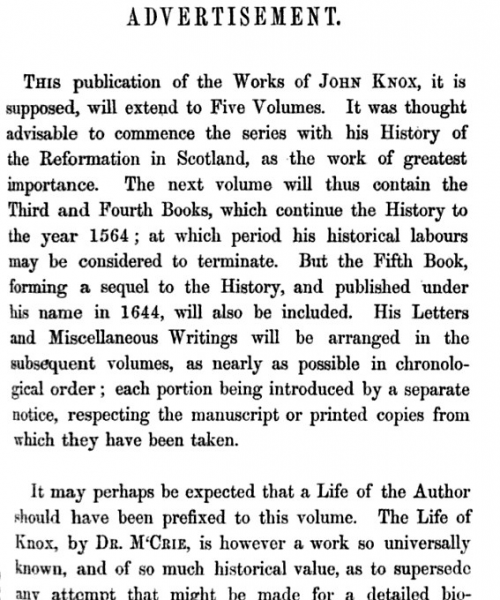

ADVERTISEMENT.

Tuts publication of the Works of Jonn Kwox, it is
supposed, will extend to Five Volumes. It was thought
advisable to commence the series with his History of
the Reformation in Scotland, as the work of greatest
importance. The next volume will thus contain the
Third and Fourth Books, which continue the History to
the year 1564; at which period his historical labours
may be considered to terminate. But the Fifth Book,
forming a sequel to the History, and published under
his name in 1644, will also be included. His Letters
and Miscellancous Writings will be arranged in the
subsequent volumes, as nearly as possible in chronolo-
gical order; each portion being introduced by a separate
avtice, respecting the manuscript or printed copies from
which they have been taken.

It may perhaps be expected that a Life of the Author
thould have been prefixed to this volume. The Life of
Knox, by Dr. M-Crig, is however a work so universally
known, and of so much historical value, as to su

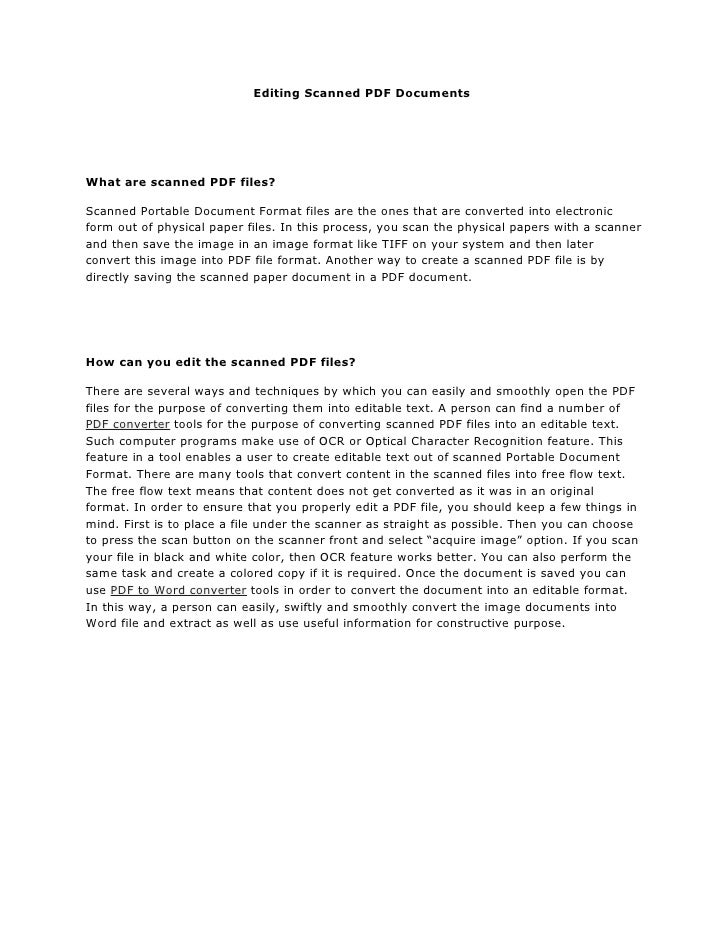

Editing Scanned PDF Documents

What are scanned PDF files?

Scanned Portable Document Format fifes are the ones that are converted into electronic
form out of physical paper files. In this process, you scan the physical papers with a scanner
and then save the image in an image format like TIFF on your system and then later
convert this image into PDF file format. Another way to create a scanned PDF file is by
directly saving the scanned paper document in a PDF document.

How can you edit the scanned PDF files?

There are several ways and techniques by which you can easity and smoothly open the PDF
files for the purpose of converting them into editable text. A person can find a number of
PDF converter tools for the purpose of converting scanned PDF files into an editable text.
Such computer programs make use of OCR or Optical Character Recognition feature. This
feature in a tool enables a user to create editable text out of scanned Portable Document
Format. There are many tools that con

In [9]:
for r in result.distinct().collect():
  display_image(r.image)
  print (r.text)

Saving intermediate processing results as jpg

In [10]:
for r in result.distinct().collect():

    img = to_pil_image(r.binarized_image, r.binarized_image.mode)
    img.save('img_binarized.jpg')
